Di project ini saya ingin membuat model Machine Learning tipe Classification dengan data dari https://www.kaggle.com/competitions/walmart-recruiting-trip-type-classification/data?select=train.csv.zip tentang kategori type perjalanan belanja . Dataset kita terdiri dari dua file terpisah, train.csv dan test.csv. Kita akan gunakan train.csv saja.

model machine learning kita bertujuan untuk melakukan pengkategorian jenis perjalanan belanja berdasarkan barang yang dibeli pelanggan.

In [80]:
# import package yang diperlukan
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use(['ggplot'])

import seaborn as sns
sns.set_style('whitegrid')

# import package2 dari sklearn disini
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.datasets import load_digits, load_wine

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


In [5]:
# explore data
df_trip_train = pd.read_csv("E:\Belajar_Python/train.csv")

In [6]:
df_trip_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   TripType               647054 non-null  int64  
 1   VisitNumber            647054 non-null  int64  
 2   Weekday                647054 non-null  object 
 3   Upc                    642925 non-null  float64
 4   ScanCount              647054 non-null  int64  
 5   DepartmentDescription  645693 non-null  object 
 6   FinelineNumber         642925 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 34.6+ MB


In [7]:
#cek data yang null
df_trip_train.isnull().sum()


TripType                    0
VisitNumber                 0
Weekday                     0
Upc                      4129
ScanCount                   0
DepartmentDescription    1361
FinelineNumber           4129
dtype: int64

terdapat 3 filed yang memiliki missing value yaitu : Upc , DepartmentDescription , dan FinelineNumber
untuk kolom2 yang ada sedikit missing value nya, kita bisa pilih mau drop baris yang ada missing value nya atau kita fill missing value tersebut mungkin dengan mean, median, atau mode data kolom tersebut.

untuk setiap kolom yang ada missing value nya, aku mau cek kolom tersebut punya data seperti apa

In [8]:
df_trip_train

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0
...,...,...,...,...,...,...,...
647049,39,191346,Sunday,3.239000e+10,1,PHARMACY OTC,1118.0
647050,39,191346,Sunday,7.874205e+09,1,FROZEN FOODS,1752.0
647051,39,191346,Sunday,4.072000e+03,1,PRODUCE,4170.0
647052,8,191347,Sunday,4.190008e+09,1,DAIRY,1512.0


In [9]:
for col in df_trip_train.columns[df_trip_train.isnull().any()]:
    print(col)
    print("Unique values:", df_trip_train[col].nunique())
    print(df_trip_train[col].value_counts())
    print()

Upc
Unique values: 97714
4.011000e+03    7657
6.053886e+10    2501
7.874235e+09    2067
7.874235e+09    1883
4.046000e+03    1652
                ... 
8.022596e+09       1
7.678985e+10       1
3.378922e+09       1
5.200024e+09       1
8.430051e+10       1
Name: Upc, Length: 97714, dtype: int64

DepartmentDescription
Unique values: 68
GROCERY DRY GOODS         70402
DSD GROCERY               68332
PRODUCE                   51115
DAIRY                     43820
PERSONAL CARE             41969
                          ...  
LARGE HOUSEHOLD GOODS        77
CONCEPT STORES               35
OTHER DEPARTMENTS            29
SEASONAL                     29
HEALTH AND BEAUTY AIDS        2
Name: DepartmentDescription, Length: 68, dtype: int64

FinelineNumber
Unique values: 5195
5501.0    8244
1508.0    5121
135.0     4538
808.0     4401
0.0       3837
          ... 
7838.0       1
1765.0       1
5518.0       1
3517.0       1
7320.0       1
Name: FinelineNumber, Length: 5195, dtype: int64



kita akan fill missing values dengan:
- Upc ==> Mode
- DepartmenDesrciption ==> Mode
- FinelineNumber ==> Median

In [10]:
# isi missing value kolom kolom ini dengan mode nya
col_list = ['Upc','DepartmentDescription']
for col in col_list:
    mode = df_trip_train[col].mode()[0]
    df_trip_train[col] = df_trip_train[col].fillna(value=mode)
  

In [11]:
median = df_trip_train['FinelineNumber'].median()
df_trip_train['FinelineNumber'] = df_trip_train['FinelineNumber'].fillna(value = median)

In [12]:
df_trip_train.isnull().sum().sum()

0

kita sudah merapikan datanya, tidak ada missing value lagi. berikutnya cek invalid values

In [13]:
df_trip_train.describe()

,TripType,VisitNumber,Upc,ScanCount,FinelineNumber
count,647054.000000,647054.000000,6.470540e+05,647054.000000,647054.000000
mean,58.584511,96167.640078,3.041167e+10,1.108878,3724.492342
std,157.635533,55545.485154,9.094255e+10,0.700776,2772.239672
min,3.000000,5.000000,8.340000e+02,-12.000000,0.000000
25%,27.000000,49268.000000,3.400000e+09,1.000000,1404.000000
50%,39.000000,97074.000000,7.047029e+09,1.000000,3352.000000
75%,40.000000,144316.000000,3.004167e+10,1.000000,5501.000000
max,999.000000,191347.000000,9.789707e+11,71.000000,9998.000000


#Explorasi Data Analysis



#Train Type

In [16]:
df_trip_train.TripType.nunique()

38

C:\Users\LPDP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='TripType', ylabel='count'>

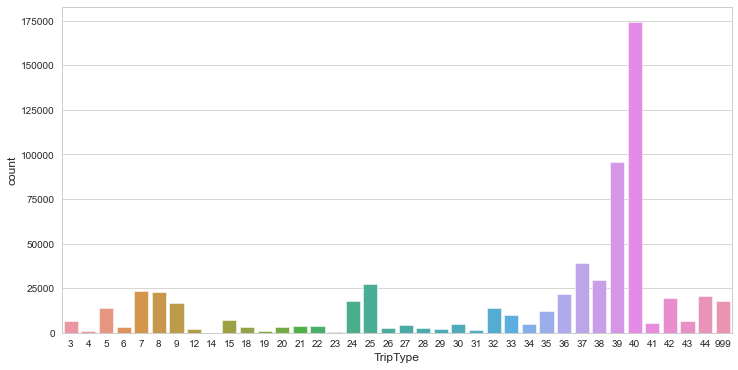

In [43]:
plt.figure(figsize=(12,6))
sns.countplot(df_trip_train.TripType)

#Visit Number

#VisitNumber

In [20]:
df_trip_train.VisitNumber.nunique()

95674

C:\Users\LPDP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='VisitNumber', ylabel='Density'>

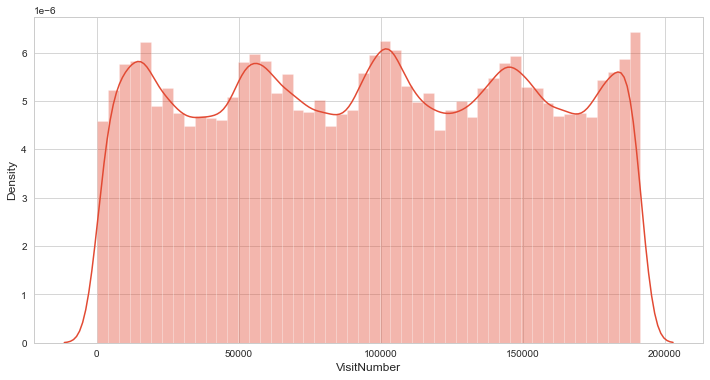

In [21]:
plt.figure(figsize=(12,6))
sns.distplot(df_trip_train.VisitNumber)

terlihat bahwa visitnumber terdistribusi seragam (uniform distribution)

#Weekday Distribution

C:\Users\LPDP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Weekday', ylabel='count'>

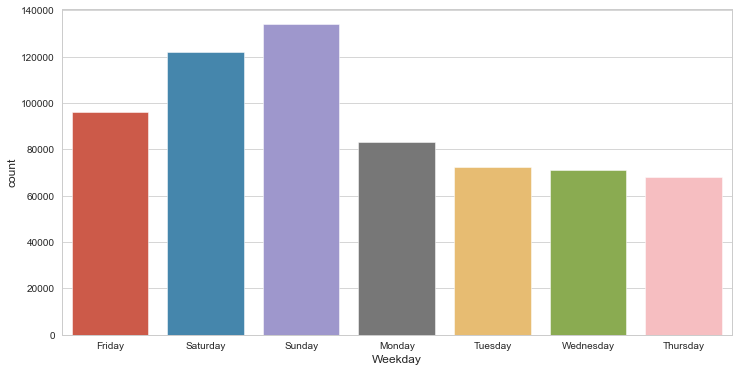

In [23]:
plt.figure(figsize=(12,6))
sns.countplot(df_trip_train.Weekday)

In [24]:
df_trip_train.groupby('Weekday')['Weekday'].count()

Weekday
Friday        96247
Monday        83130
Saturday     122096
Sunday       133975
Thursday      67962
Tuesday       72529
Wednesday     71115
Name: Weekday, dtype: int64

In [25]:
def weekday_to_num(x):
  if x=='Monday':
    return 0
  elif x=='Tuesday':
    return 1
  elif x=='Wednesday':
    return 2
  elif x=='Thursday':
    return 3
  elif x=='Friday':
    return 4
  elif x=='Saturday':
    return 5
  elif x=='Sunday':
    return 6 

In [26]:
df_trip_train['weekday_num']=df_trip_train.Weekday.apply(weekday_to_num)

C:\Users\LPDP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


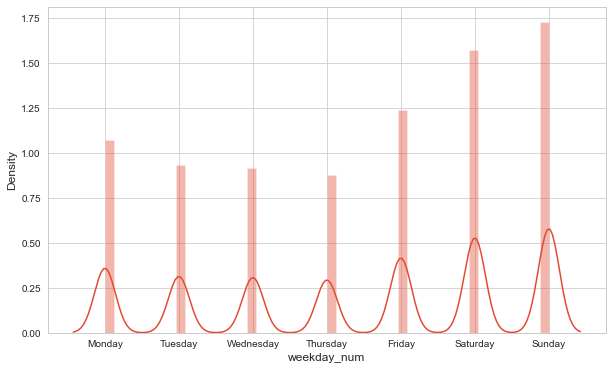

In [27]:
fig,axs=plt.subplots(figsize=(10,6))
sns.distplot(df_trip_train['weekday_num'],ax=axs)
ticks=list(range(0,7))
axs.set_xticks(ticks)
x_tick_label=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
axs.set_xticklabels(x_tick_label)
plt.show()

 ada lebih banyak kemungkinan kunjungan untuk akhir pekan. Kamis adalah hari dengan jumlah kunjungan terendah

#DepartementDescription

In [29]:
df_trip_train.DepartmentDescription.value_counts()

GROCERY DRY GOODS         71763
DSD GROCERY               68332
PRODUCE                   51115
DAIRY                     43820
PERSONAL CARE             41969
                          ...  
LARGE HOUSEHOLD GOODS        77
CONCEPT STORES               35
OTHER DEPARTMENTS            29
SEASONAL                     29
HEALTH AND BEAUTY AIDS        2
Name: DepartmentDescription, Length: 68, dtype: int64

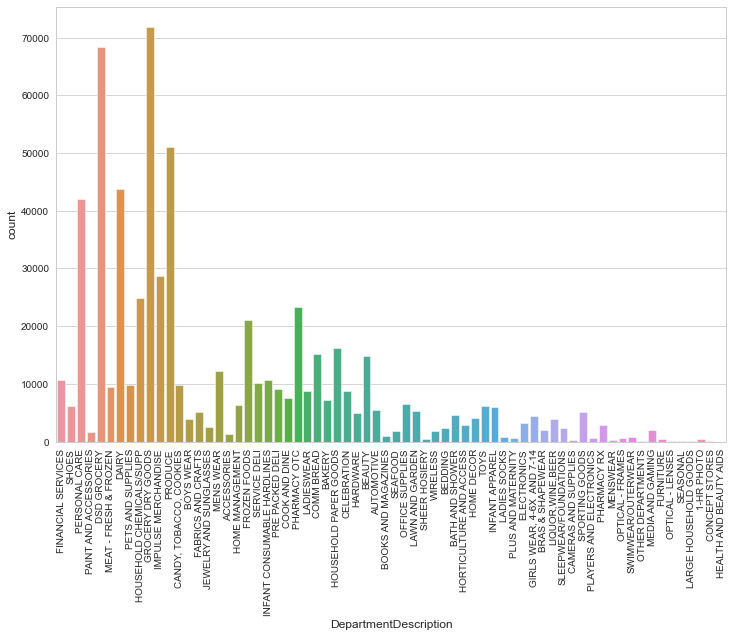

In [30]:
plt.figure(figsize=(12,8))
sns.countplot(x='DepartmentDescription',data=df_trip_train)
plt.xticks(rotation=90)
plt.show()

In [31]:
df_trip_train.groupby('DepartmentDescription')['DepartmentDescription'].count()

DepartmentDescription
1-HR PHOTO                394
ACCESSORIES              1318
AUTOMOTIVE               5414
BAKERY                   7168
BATH AND SHOWER          4582
                         ... 
SLEEPWEAR/FOUNDATIONS    2376
SPORTING GOODS           5087
SWIMWEAR/OUTERWEAR        860
TOYS                     6107
WIRELESS                 1898
Name: DepartmentDescription, Length: 68, dtype: int64

distribusi datanya terlihat miring ke kiri, PERSONAL CARE, DSD GROCERIES, DAIRY, PRODUCE, GROCERY DRY GOODS kategori ini menjadi kategori yang dominan dalam sebaran data

#FinelineNumber

C:\Users\LPDP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='FinelineNumber', ylabel='Density'>

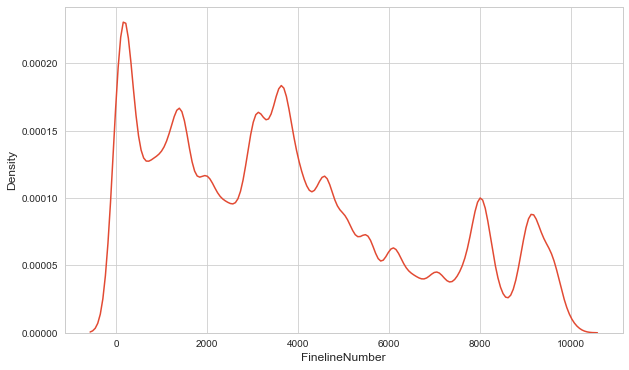

In [39]:
plt.figure(figsize=(10,6))
sns.distplot(df_trip_train.FinelineNumber,hist=False)

FinelineNumber terlihat dari sebarannya merupakan data yang terdistribusi multimodal distribution

#UPc

C:\Users\LPDP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Upc', ylabel='Density'>

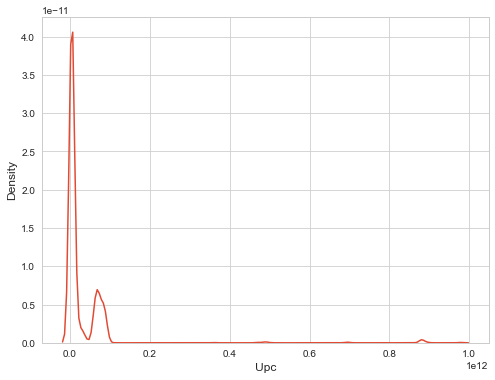

In [46]:
plt.figure(figsize=(8,6))
sns.distplot(df_trip_train.Upc,hist=False)

# Data Preprocessing

Penyiapan data untuk proses pemodelan klasifikasi

membuat field baru 'num_of_products' yang menunjukkan jumlah produk yang dibeli untuk setiap 'VisitNumber' berdasarkan 'Upc'

In [47]:
products_per_visit=df_trip_train.groupby(['VisitNumber'])['Upc'].count()

In [48]:
products_per_visit_dict=dict(products_per_visit)

In [50]:
df_trip_train['num_of_products_for_VisitNumber']=df_trip_train['VisitNumber'].apply(lambda x:products_per_visit_dict.get(x,0))

In [51]:
df_trip_train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,23
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,23


C:\Users\LPDP\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='num_of_products_for_VisitNumber', ylabel='Density'>

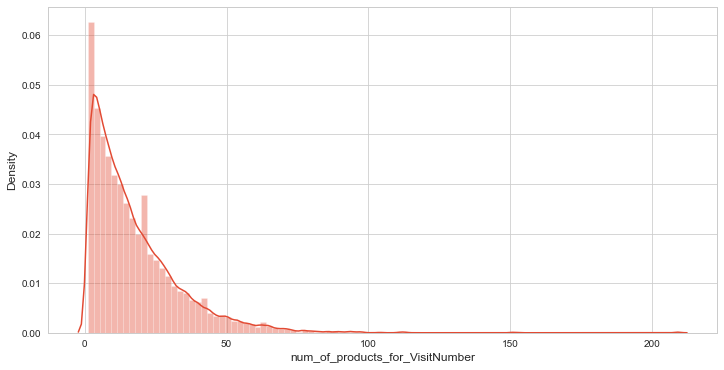

In [52]:
plt.figure(figsize=(12,6))
sns.distplot(df_trip_train.num_of_products_for_VisitNumber,bins=99)

distribusi jumlah produk yang dibeli untuk setiap VisitNumer terlihat miring. Ada lebih banyak kemungkinan untuk membeli lebih sedikit jumlah produk

Kita akan memeriksa apakah num_of_products entah bagaimana terkait dengan hari di mana belanja dilakukan.

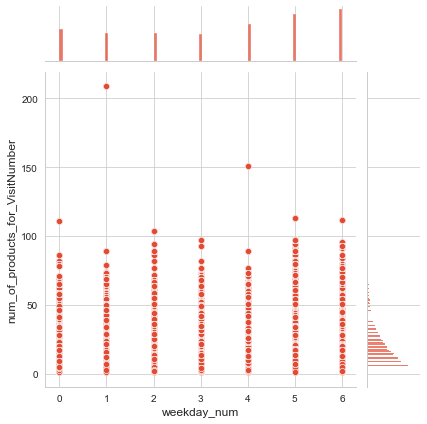

In [54]:
sns.jointplot(y='num_of_products_for_VisitNumber',x='weekday_num',data=df_trip_train)

<AxesSubplot:xlabel='Weekday', ylabel='num_of_products_for_VisitNumber'>

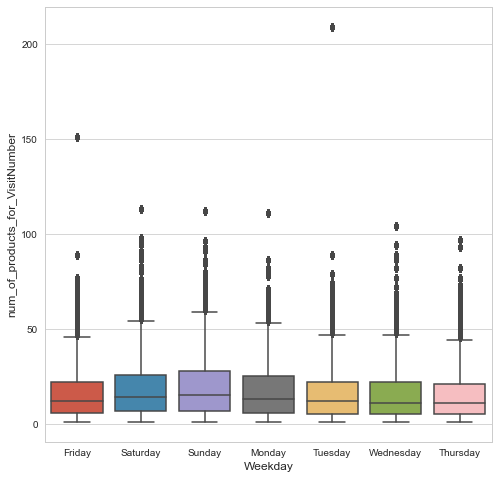

In [57]:
plt.figure(figsize=(8,8))
sns.boxplot(x='Weekday',y='num_of_products_for_VisitNumber',data=df_trip_train)

In [ ]:
Pada akhir pekan dan pada hari Senin ada lebih banyak produk yang dibeli per VisitNumber

In [58]:
df_trip_train.FinelineNumber.nunique()

5195

In [59]:
groupby_dept=df_trip_train.groupby(['Department_num'])

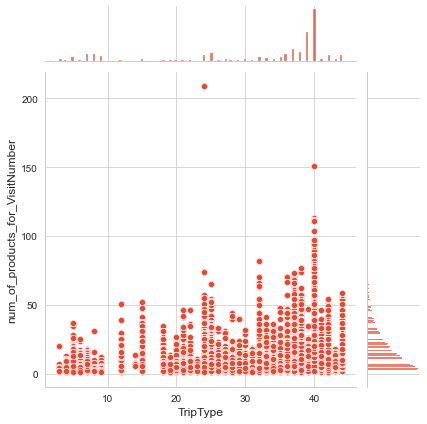

In [60]:
sns.jointplot(y='num_of_products_for_VisitNumber',x='TripType',data=df_trip_train[df_trip_train['TripType']<900])

<AxesSubplot:xlabel='TripType', ylabel='num_of_products_for_VisitNumber'>

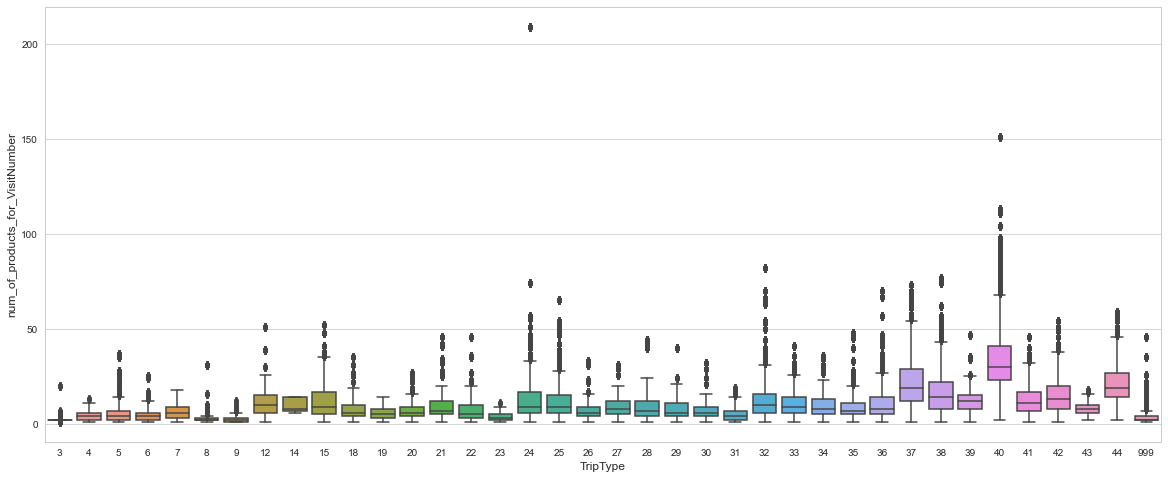

In [61]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='num_of_products_for_VisitNumber',data=df_trip_train)

In [62]:
Department_num_of_products=dict(df_trip_train.groupby('Department_num')['Upc'].count())

In [64]:
df_trip_train['num_of_products_for_department']=df_trip_train['Department_num'].apply(lambda x:Department_num_of_products.get(x))

<AxesSubplot:xlabel='TripType', ylabel='num_of_products_for_department'>

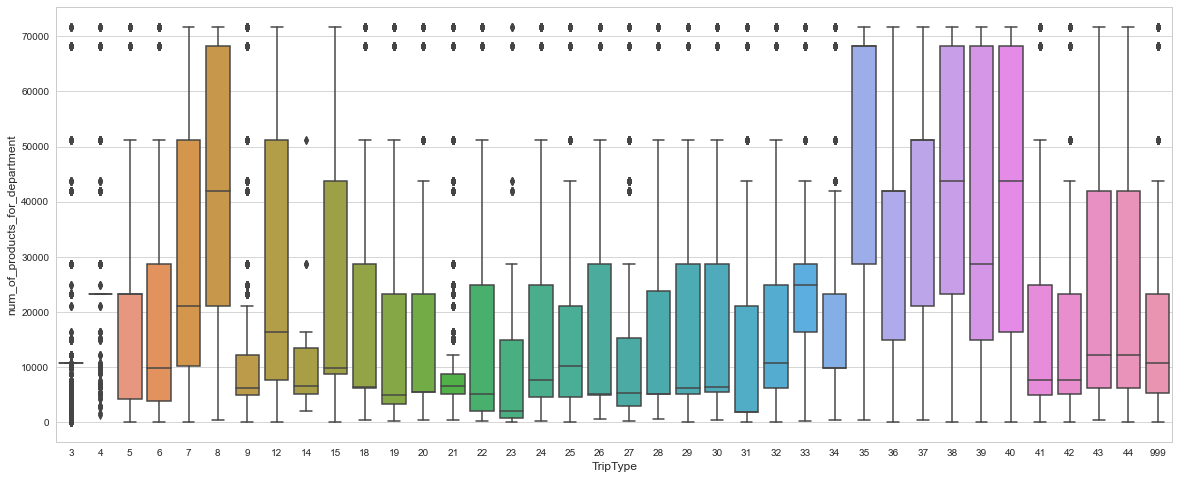

In [65]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='num_of_products_for_department',data=df_trip_train)

In [107]:
one_hot_encoded_weekday=pd.get_dummies(df_trip_train['Weekday'],drop_first=False)

In [106]:
one_hot_encoded_weekday.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [108]:
df_trip_train=pd.concat([df_trip_train,one_hot_encoded_weekday],axis=1)

In [69]:
df_trip_train.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,10723,1,0,0,0,0,0,0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,6099,1,0,0,0,0,0,0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,41969,1,0,0,0,0,0,0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,23,1720,1,0,0,0,0,0,0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,23,1720,1,0,0,0,0,0,0


In [70]:
df_trip_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 647054 entries, 0 to 647053
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   TripType                         647054 non-null  int64  
 1   VisitNumber                      647054 non-null  int64  
 2   Weekday                          647054 non-null  object 
 3   Upc                              647054 non-null  float64
 4   ScanCount                        647054 non-null  int64  
 5   DepartmentDescription            647054 non-null  object 
 6   FinelineNumber                   647054 non-null  float64
 7   weekday_num                      647054 non-null  int64  
 8   Department_num                   647054 non-null  int64  
 9   num_of_products_for_VisitNumber  647054 non-null  int64  
 10  num_of_products_for_department   647054 non-null  int64  
 11  Friday                           647054 non-null  uint8  
 12  Mo

# Splitting Data

Memisahkan data menjadi X dan Y dan kemudian membuat train, cross validation dan test sets

In [71]:
Y=df_trip_train.TripType
X=df_trip_train.drop(columns=['TripType'])

In [72]:
X['FinelineCat']=pd.cut(X['FinelineNumber'],bins=50,labels=False)

In [73]:
X.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,FinelineCat
0,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0,4,0,1,10723,1,0,0,0,0,0,0,5
1,7,Friday,6.053882e+10,1,SHOES,8931.0,4,1,2,6099,1,0,0,0,0,0,0,44
2,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0,4,2,2,41969,1,0,0,0,0,0,0,22
3,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0,4,3,23,1720,1,0,0,0,0,0,0,17
4,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0,4,3,23,1720,1,0,0,0,0,0,0,5


In [74]:
Y.head()

0    999
1     30
2     30
3     26
4     26
Name: TripType, dtype: int64

In [75]:
df_trip_train.shape

(647054, 18)

In [105]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.2)
x_train,x_cv,y_train,y_cv=train_test_split(x_train,y_train,stratify=y_train,test_size=0.2)

In [77]:
print(x_train.shape,x_cv.shape,x_test.shape)

(414114, 18) (103529, 18) (129411, 18)


In [78]:
print(y_train.shape,y_cv.shape,y_test.shape)

(414114,) (103529,) (129411,)


#Response encoding untuk fitur kategori lainnya 

# Response encoding for rest of the rest of the categorical features

Creating a new temporary dataframe from x_train and y_train for getting lookup table for response coding of some categorical features

In [110]:
x_train_res=x_train.copy()

In [111]:
x_train_res['class']=y_train.values

In [112]:
y_train.unique()

array([ 40,  36,  39,  32,  21,   7,  20,  37,   9,  38,  42,  35,  30,
        25,   8,  24,   5, 999,  44,  28,  41,  15,  26,  31,  22,  43,
        14,   6,  34,  33,   4,   3,  27,  18,  29,  12,  23,  19],
      dtype=int64)

In [113]:
x_train_res.head()

,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber,weekday_num,Department_num,num_of_products_for_VisitNumber,num_of_products_for_department,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,FinelineCat,class
157351,47970,Friday,5.410002e+09,2,GROCERY DRY GOODS,2503.0,4,9,35,71763,1,0,0,0,0,0,0,12,40
323307,97018,Saturday,1.284410e+09,1,AUTOMOTIVE,257.0,5,32,37,5414,0,0,1,0,0,0,0,1,36
48033,14079,Sunday,4.900005e+09,1,DSD GROCERY,9519.0,6,4,17,68332,0,0,0,1,0,0,0,47,39
611335,182148,Saturday,7.874209e+09,1,HOUSEHOLD PAPER GOODS,4010.0,5,28,31,16274,0,0,1,0,0,0,0,20,40
307525,92668,Friday,7.780258e+09,1,BEAUTY,2005.0,4,31,7,14865,1,0,0,0,0,0,0,10,32


Functions for response encoding

In [115]:
from tqdm import tqdm
def get_lookup_dict(alpha,feature):
  value_count = x_train_res[feature].value_counts()
  lookup_dict = dict()
  for i, denominator in tqdm(value_count.items()):
    vec = []
    for k in y_train.unique():
      cls_cnt = x_train_res.loc[(x_train_res['class']==k) & (x_train_res[feature]==i)]
      vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
    
    lookup_dict[i]=vec
  
  return lookup_dict

In [116]:
from tqdm import tqdm
def get_encoded_feature(alpha,feature,df,lookup_dict):
  #lookup_dict=get_lookup_dict(alpha,feature,df)
  value_count = x_train_res[feature].value_counts()
  gv_fea = []
  for index, row in tqdm(df.iterrows()):

    if row[feature] in dict(value_count).keys():
        gv_fea.append(lookup_dict[row[feature]])
    else:
        gv_fea.append([1/38]*38)
#           gv_fea.append([-1,-1,-1,-1,-1,-1,-1,-1,-1])
  
  return gv_fea

response encoding 'DepartmentDescription'

In [117]:
lookup_dict_DD=get_lookup_dict(1,'DepartmentDescription')

68it [01:31,  1.35s/it]


In [118]:
alpha = 1
train_department_feature_responseCoding=np.array(get_encoded_feature(alpha, "DepartmentDescription", x_train,lookup_dict_DD))

414114it [03:13, 2140.80it/s]


In [119]:
test_department_feature_responseCoding=np.array(get_encoded_feature(alpha, "DepartmentDescription", x_test,lookup_dict_DD))

129411it [00:59, 2158.44it/s]


In [120]:
cv_department_feature_responseCoding=np.array(get_encoded_feature(alpha, "DepartmentDescription", x_cv,lookup_dict_DD))

103529it [00:46, 2208.47it/s]


In [121]:
train_department_feature_responseCoding.shape

(414114, 38)

In [122]:
test_department_feature_responseCoding.shape

(129411, 38)

In [123]:
cv_department_feature_responseCoding.shape

(103529, 38)

response encoding 'ScanCount'

In [126]:
df_trip_train.ScanCount.nunique()

39

In [127]:
lookup_dict_SS=get_lookup_dict(1,'ScanCount')

35it [00:03,  9.26it/s]


In [128]:
train_ScanCount_feature_responseCoding=np.array(get_encoded_feature(alpha, "ScanCount", x_train,lookup_dict_SS))

414114it [02:24, 2872.09it/s]


In [ ]:
test_ScanCount_feature_responseCoding=np.array(get_encoded_feature(alpha, "ScanCount", x_test,lookup_dict_SS))

In [ ]:
cv_ScanCount_feature_responseCoding=np.array(get_encoded_feature(alpha, "ScanCount", x_cv,lookup_dict_SS))

In [ ]:
train_ScanCount_feature_responseCoding.shape

In [ ]:
test_ScanCount_feature_responseCoding.shape

In [ ]:
cv_ScanCount_feature_responseCoding.shape

#response encoding 'FinelineCat'

In [ ]:
df_trip_train.FinelineNumber.nunique()

In [ ]:
df_trip_train.FinelineNumber

In [ ]:
df_trip_train['FinelineCat']=pd.cut(df_trip_train['FinelineNumber'],bins=50,labels=False)

In [ ]:
plt.figure(figsize=(9,6))
sns.distplot(pd_trip_train['FinelineCat'])

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(x='TripType',y='FinelineCat',data=df_trip_train)

In [ ]:
df_trip_train.info()